In [57]:
%matplotlib inline

In [58]:
#export
from exp.nb_00 import *
import operator

def test(a,b,cmp,cname=None):
    if cname is None: cname=cmp.__name__
    assert cmp(a,b),f"{cname}:\n{a}\n{b}"

def test_eq(a,b): test(a,b,operator.eq,'==')

In [59]:
#export
from pathlib import Path
from IPython.core.debugger import set_trace
from fastai import datasets
import pickle, gzip, math, torch, matplotlib as mathPlotLib
import matplotlib.pyplot as plotter
from torch import tensor

MNIST_URL='http://deeplearning.net/data/mnist/mnist.pkl'

### Download Data

In [60]:
pathToDataSet = datasets.download_data(MNIST_URL, ext=".gz")

In [61]:
with gzip.open(pathToDataSet, 'rb') as file:
    ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(file, encoding='latin-1')

### Convert To tensors

In [62]:
x_train,y_train,x_valid,y_valid = map(tensor, (x_train,y_train,x_valid,y_valid))

In [63]:
[x_train.shape, y_train.shape, x_valid.shape, y_valid.shape]

[torch.Size([50000, 784]),
 torch.Size([50000]),
 torch.Size([10000, 784]),
 torch.Size([10000])]

In [64]:
trainingImage = x_train[0]

In [65]:
trainingImage.shape

torch.Size([784])

Training images are stored as vectors that can be reshaped into 28x28 tensors

In [66]:
trainingImage.view(28,28).shape

torch.Size([28, 28])

**Taking a peek at the data**

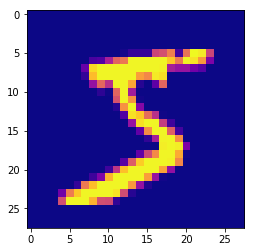

In [67]:
plotter.imshow(trainingImage.view(28,28))

### Change default color mapping to plasma

In [68]:
mathPlotLib.rcParams['image.cmap'] = 'plasma'

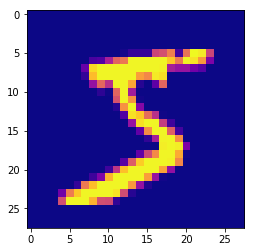

In [69]:
plotter.imshow(trainingImage.view(28,28))

We need two things for our models:
- Weighted matrices that is intialized with random values who (rows or columns) have a mean of zero with a standard devation of something
- A Bias Vector

**Weighted Matrix**
- Needs to have the rows equal the input vector's length (784 in this case) and have columns equal to the number of final activations 10 (the number of digits 0-9)

In [70]:
weights = torch.randn(784, 10); (weights.shape, weights.mean())

(torch.Size([784, 10]), tensor(-0.0038))

In [71]:
bias = torch.zeros(784); bias.shape

torch.Size([784])

**Naive Matrix Multiplication**

In [72]:
def naiveMatrixMultiplication(A, B):
    aRows, aColumns = A.shape
    bRows, bColumns = B.shape
    assert aColumns == bRows, "Cannot multiply matrices {}x{} and {}x{}".format(aRows, aColumns, bRows, bColumns)
    C = torch.zeros(aRows, bColumns)
    for i in range(aRows):
        for j in range(bColumns):
            for k in range(bRows):
                C[i,j] += A[i,k] * B[k,j]
    return C

In [73]:
randoA = torch.randn(2,4)
randoB = torch.randn(4,2)

In [74]:
%time matrixMultiplicationResult = naiveMatrixMultiplication(randoA, randoB)

CPU times: user 593 µs, sys: 208 µs, total: 801 µs
Wall time: 512 µs


In [75]:
%time expected = randoA @ randoB;

CPU times: user 51 µs, sys: 17 µs, total: 68 µs
Wall time: 84.9 µs


In [76]:
#export
def near(A,B): return torch.allclose(A, B, rtol=1e-3, atol=1e-5)
def testNear(A,B): test(A,B,near)

In [77]:
testNear(matrixMultiplicationResult, expected)

**Elementwise Matrix Multipliation**

In [78]:
A = torch.tensor([9,8,7]);
B = torch.tensor([10,20,30]).unsqueeze(-1)
C = B.squeeze(1)
(A,B,C)

(tensor([9, 8, 7]), tensor([[10],
         [20],
         [30]]), tensor([10, 20, 30]))

In [79]:
(A.shape, B.shape, C.shape)

(torch.Size([3]), torch.Size([3, 1]), torch.Size([3]))

In [80]:
A + B

tensor([[19, 18, 17],
        [29, 28, 27],
        [39, 38, 37]])

In [81]:
A + C

tensor([19, 28, 37])

In [82]:
(A + C).sum()

tensor(84)

In [83]:
def elementWiseMatrixMultiplication(A, B):
    aRows, aColumns = A.shape
    bRows, bColumns = B.shape
    assert aColumns == bRows, "Cannot multiply matrices {}x{} and {}x{}".format(aRows, aColumns, bRows, bColumns)
    C = torch.zeros(aRows, bColumns)
    for i in range(aRows):
        for j in range(bColumns):
            C[i,j] = (A[i,:] * B[:,j]).sum()
    return C

In [84]:
%time elementWiseResult = elementWiseMatrixMultiplication(randoA, randoB)

CPU times: user 810 µs, sys: 0 ns, total: 810 µs
Wall time: 487 µs


In [85]:
testNear(elementWiseResult, expected)

**Broadcasting Matrix Multiplication**

In [86]:
A.shape

torch.Size([3])

In [87]:
A[None].shape

torch.Size([1, 3])

In [88]:
A[:,None]

tensor([[9],
        [8],
        [7]])

In [89]:
randoA[0]

tensor([ 0.9916,  0.0172, -1.7137, -0.9334])

In [90]:
randoA[0].unsqueeze(-1)

tensor([[ 0.9916],
        [ 0.0172],
        [-1.7137],
        [-0.9334]])

In [91]:
randoA[0][:,None]

tensor([[ 0.9916],
        [ 0.0172],
        [-1.7137],
        [-0.9334]])

In [92]:
(randoA[0][:,None] * randoB).sum(dim=0)

tensor([0.1602, 2.3930])

In [93]:
def broadcastingMatrixMultiplication(A, B):
    aRows, aColumns = A.shape
    bRows, bColumns = B.shape
    assert aColumns == bRows, "Cannot multiply matrices {}x{} and {}x{}".format(aRows, aColumns, bRows, bColumns)
    C = torch.zeros(aRows, bColumns)
    for i in range(aRows):
        C[i] = (A[i][:,None] * B).sum(dim=0)
    return C

In [94]:
%time broadcastingResult = broadcastingMatrixMultiplication(randoA, randoB)

CPU times: user 279 µs, sys: 97 µs, total: 376 µs
Wall time: 243 µs


In [95]:
testNear(broadcastingResult, expected)

**Einsteinium Multiplication**

In [96]:
def einsteinMatrixMultiplication(A, B):
    aRows, aColumns = A.shape
    bRows, bColumns = B.shape
    assert aColumns == bRows, "Cannot multiply matrices {}x{} and {}x{}".format(aRows, aColumns, bRows, bColumns)
    return torch.einsum("ab,bc->ac",A, B)

In [97]:
%time einsteinResult = einsteinMatrixMultiplication(randoA, randoB)

CPU times: user 95 µs, sys: 33 µs, total: 128 µs
Wall time: 135 µs


In [98]:
(randoA.shape, randoB.shape, einsteinResult.shape)

(torch.Size([2, 4]), torch.Size([4, 2]), torch.Size([2, 2]))

In [99]:
testNear(einsteinResult, expected)

**Pytorch Multiplication**

In [100]:
%time pytorchMultiplicationResult = randoA @ randoB

CPU times: user 52 µs, sys: 18 µs, total: 70 µs
Wall time: 87.3 µs


In [101]:
testNear(pytorchMultiplicationResult, expected)

In [102]:
%time pytorchMatMulResult = randoA.matmul(randoB)

CPU times: user 44 µs, sys: 16 µs, total: 60 µs
Wall time: 76.5 µs


In [103]:
testNear(pytorchMultiplicationResult, expected)

In [104]:
randoACuda = randoA.cuda()
randoBCuda = randoB.cuda()

In [105]:
%time pytorchCudaMultiplicationResult = randoACuda @ randoBCuda

CPU times: user 90 µs, sys: 31 µs, total: 121 µs
Wall time: 126 µs


In [106]:
testNear(pytorchCudaMultiplicationResult, expected.cuda())

In [109]:
%time pytorchCudaMatMulResult = randoACuda.matmul(randoBCuda)

CPU times: user 638 µs, sys: 219 µs, total: 857 µs
Wall time: 449 µs


In [108]:
testNear(pytorchCudaMatMulResult, expected.cuda())